In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from functools import reduce
import numpy as np
import libpysal as lps
import seaborn as sns
import libpysal as lps
import pysal as ps
from libpysal.weights import Queen, Rook, KNN
from shapely import wkt
from scipy.spatial import cKDTree
import sklearn.model_selection as model_select
from math import sqrt
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from libpysal import weights
try:
    from scipy.optimize import minimize_scalar
    minimize_scalar_available = True
except ImportError:
    minimize_scalar_available = False
import warnings
warnings.simplefilter('ignore')

In [2]:
pd.set_option('display.max_rows', 1000)

In [3]:
#wheat residue
wheat18=pd.read_csv("dataset/production/Wheat_2018.csv",usecols=["Area Code (FAO)","Wheat_Residue"])

In [4]:
wheat18.isnull().sum()

Area Code (FAO)    0
Wheat_Residue      0
dtype: int64

In [5]:
#read country code
country_code=pd.read_csv("dataset/country_data.csv",usecols=["Country Code","Country","ISO2 Code","ISO3 Code"])
country_code.head()

,Country Code,Country,ISO2 Code,ISO3 Code
0,2,Afghanistan,AF,AFG
1,5100,Africa,NaN,X06
2,3,Albania,AL,ALB
3,4,Algeria,DZ,DZA
4,5,American Samoa,AS,ASM


In [6]:
#country area
area=pd.read_csv("dataset/cropland/country_area.csv",usecols=["country_area","ISO3 Code"])
area.head()

,ISO3 Code,country_area
0,ABW,180.0
1,AFG,652860.0
2,AGO,1246700.0
3,ALB,28750.0
4,AND,470.0


In [7]:
#read shapefile
poly=gpd.read_file("dataset/wb_countries_admin0_10m/wb_countries_admin0_10m.shp")
poly.columns

Index(['OBJECTID', 'featurecla', 'LEVEL', 'TYPE', 'FORMAL_EN', 'FORMAL_FR',
       'POP_EST', 'POP_RANK', 'GDP_MD_EST', 'POP_YEAR', 'LASTCENSUS',
       'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'FIPS_10_', 'ISO_A2', 'ISO_A3',
       'ISO_A3_EH', 'ISO_N3', 'UN_A3', 'WB_A2', 'WB_A3', 'CONTINENT',
       'REGION_UN', 'SUBREGION', 'REGION_WB', 'NAME_AR', 'NAME_BN', 'NAME_DE',
       'NAME_EN', 'NAME_ES', 'NAME_FR', 'NAME_EL', 'NAME_HI', 'NAME_HU',
       'NAME_ID', 'NAME_IT', 'NAME_JA', 'NAME_KO', 'NAME_NL', 'NAME_PL',
       'NAME_PT', 'NAME_RU', 'NAME_SV', 'NAME_TR', 'NAME_VI', 'NAME_ZH',
       'WB_NAME', 'WB_RULES', 'WB_REGION', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')

In [8]:
poly.loc[50,"ISO_A3_EH"]="NOR"

In [9]:
#merge country code and shapefile
country_poly=pd.merge(country_code,poly,left_on="ISO3 Code",right_on="ISO_A3_EH",how="inner")
country_poly.head()

,Country Code,Country,ISO2 Code,ISO3 Code,OBJECTID,featurecla,LEVEL,TYPE,FORMAL_EN,FORMAL_FR,...,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,WB_NAME,WB_RULES,WB_REGION,Shape_Leng,Shape_Area,geometry
0,2,Afghanistan,AF,AFG,126,Admin-0 country,2,Sovereign country,Islamic State of Afghanistan,None,...,Afghanistan,Afganistan,Afghanistan,阿富汗,Afghanistan,None,SOA,52.765827,62.591664,"POLYGON ((74.54235 37.02167, 74.54742 37.01567..."
1,3,Albania,AL,ALB,61,Admin-0 country,2,Sovereign country,Republic of Albania,None,...,Albanien,Arnavutluk,Albania,阿尔巴尼亚,Albania,None,ECA,11.050457,3.039395,"POLYGON ((20.56715 41.87318, 20.54172 41.86158..."
2,4,Algeria,DZ,DZA,118,Admin-0 country,2,Sovereign country,People's Democratic Republic of Algeria,None,...,Algeriet,Cezayir,Algérie,阿尔及利亚,Algeria,None,MENA,71.641687,212.690941,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ..."
3,5,American Samoa,AS,ASM,228,Admin-0 country,2,Dependency,American Samoa,None,...,Amerikanska Samoa,Amerikan Samoası,Samoa thuộc Mỹ,美屬薩摩亞,American Samoa (US),Name in italic,Other,1.073705,0.015101,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576..."
4,6,Andorra,AD,AND,125,Admin-0 country,2,Sovereign country,Principality of Andorra,None,...,Andorra,Andorra,Andorra,安道尔,Andorra,None,Other,1.057953,0.049561,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ..."


In [10]:
country_poly1=pd.merge(country_poly,area,on="ISO3 Code",how="outer")
country_poly1.head()

,Country Code,Country,ISO2 Code,ISO3 Code,OBJECTID,featurecla,LEVEL,TYPE,FORMAL_EN,FORMAL_FR,...,NAME_TR,NAME_VI,NAME_ZH,WB_NAME,WB_RULES,WB_REGION,Shape_Leng,Shape_Area,geometry,country_area
0,2,Afghanistan,AF,AFG,126,Admin-0 country,2,Sovereign country,Islamic State of Afghanistan,None,...,Afganistan,Afghanistan,阿富汗,Afghanistan,None,SOA,52.765827,62.591664,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",652860.0
1,3,Albania,AL,ALB,61,Admin-0 country,2,Sovereign country,Republic of Albania,None,...,Arnavutluk,Albania,阿尔巴尼亚,Albania,None,ECA,11.050457,3.039395,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",28750.0
2,4,Algeria,DZ,DZA,118,Admin-0 country,2,Sovereign country,People's Democratic Republic of Algeria,None,...,Cezayir,Algérie,阿尔及利亚,Algeria,None,MENA,71.641687,212.690941,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",2381741.0
3,5,American Samoa,AS,ASM,228,Admin-0 country,2,Dependency,American Samoa,None,...,Amerikan Samoası,Samoa thuộc Mỹ,美屬薩摩亞,American Samoa (US),Name in italic,Other,1.073705,0.015101,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",200.0
4,6,Andorra,AD,AND,125,Admin-0 country,2,Sovereign country,Principality of Andorra,None,...,Andorra,Andorra,安道尔,Andorra,None,Other,1.057953,0.049561,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",470.0


In [11]:
#select columns
country_poly1=pd.DataFrame(country_poly1,columns=["Country Code","Country","geometry","CONTINENT","country_area"])
country_poly1.head()

,Country Code,Country,geometry,CONTINENT,country_area
0,2,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,652860.0
1,3,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,28750.0
2,4,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2381741.0
3,5,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,200.0
4,6,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,470.0


In [12]:
wheat18_g=pd.merge(country_poly1,wheat18,left_on="Country Code",right_on="Area Code (FAO)",how="outer")
wheat18_g=gpd.GeoDataFrame(wheat18_g)
wheat18_g

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Wheat_Residue
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,2.0,6.323275e+06
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,3.0,4.205145e+05
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,6.967133e+06
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,NaN,NaN
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,NaN,NaN
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,4.158000e+03
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,NaN,NaN
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,NaN,NaN
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,3.240658e+07
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,1.0,3.280428e+05


In [13]:
wheat18_g=wheat18_g.drop([227,228])

Text(0.5, 1, 'Wheat Residues (2018)')

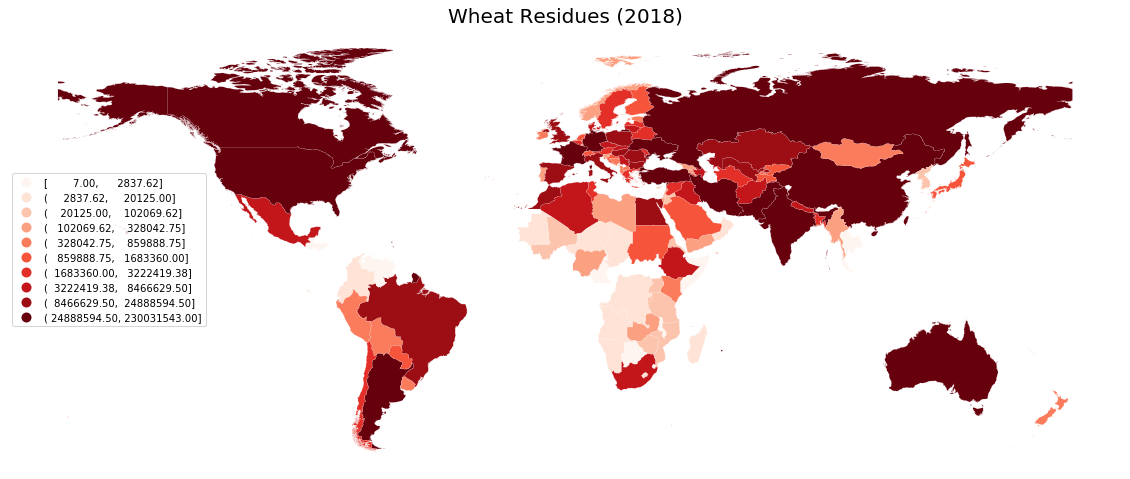

In [14]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
#barley17_g.plot(column='barley_value', missing_kwds={'color': 'lightgrey'})
wheat18_g.plot(column='Wheat_Residue',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
               
       )
ax.set_axis_off()
ax.set_title("Wheat Residues (2018)", fontsize=20)

In [15]:
missing_num_africa=len(wheat18_g[(wheat18_g["CONTINENT"]=="Africa") & (np.isnan(wheat18_g["Wheat_Residue"].values))])

In [16]:
avg_africa=(51257011.75-(wheat18_g[(wheat18_g["CONTINENT"]=="Africa") & (np.isfinite(wheat18_g["Wheat_Residue"].values))]["Wheat_Residue"].sum()))/missing_num_africa
avg_africa

19381.425

In [17]:
#fill missing values in Africa
wheat18_g.loc[(wheat18_g["CONTINENT"]=="Africa") & (np.isnan(wheat18_g["Wheat_Residue"].values)),["Wheat_Residue"]]=avg_africa
wheat18_g

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Wheat_Residue
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,2.0,6.323275e+06
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,3.0,4.205145e+05
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,6.967133e+06
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,NaN,NaN
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,NaN,NaN
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,4.158000e+03
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,NaN,NaN
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,NaN,NaN
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,3.240658e+07
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,1.0,3.280428e+05


In [18]:
#fill missing values outside Africa
#get centriod of each polygon
wheat18_g["centroid"]=wheat18_g["geometry"].values.centroid

In [19]:
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([wheat18_g.loc[i,"centroid"].x,wheat18_g.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        sum_r=0
        k=0
        for j in idx:
            if not np.isnan(wheat18_g.loc[j,"Wheat_Residue"]):
                k=k+1
                sum_r=sum_r+wheat18_g.loc[j,"Wheat_Residue"]
        if k!=0:
            a_sum=sum_r/k
            wheat18_g.loc[i,"Wheat_Residue"]=a_sum

while len(wheat18_g[np.isnan(wheat18_g["Wheat_Residue"].values)].index)!=0:
    ckdnearest(wheat18_g,wheat18_g[np.isnan(wheat18_g["Wheat_Residue"].values)].index)

In [20]:
len(wheat18_g[np.isnan(wheat18_g["Wheat_Residue"].values)])

0

Text(0.5, 1, 'Wheat Residues (2018)')

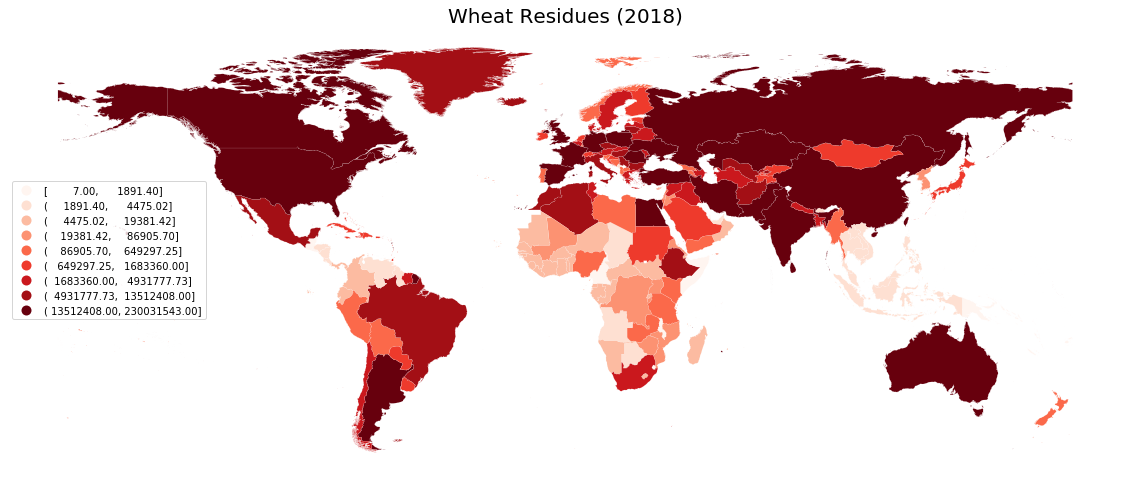

In [21]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
wheat18_g.plot(column='Wheat_Residue',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
               
       )
ax.set_axis_off()
ax.set_title("Wheat Residues (2018)", fontsize=20)

In [22]:
wheat18_g["Area Code (FAO)"]=wheat18_g["Country Code"]
wheat18_g

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Wheat_Residue,centroid
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,2.0,6.323275e+06,POINT (66.00845 33.83627)
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,3.0,4.205145e+05,POINT (20.05382 41.14248)
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,6.967133e+06,POINT (2.65309 28.14889)
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,5.0,6.492972e+05,POINT (-170.39892 -14.25494)
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,6.0,3.827832e+07,POINT (1.56076 42.54133)
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,4.158000e+03,POINT (17.53699 -12.29232)
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,258.0,1.683360e+06,POINT (-63.05857 18.22569)
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,8.0,1.683360e+06,POINT (-61.79173 17.28438)
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,3.240658e+07,POINT (-65.17819 -35.38755)
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,1.0,3.280428e+05,POINT (44.93230 40.28813)


In [23]:
#do spatial analysis
#global spatial analysis
wheat18_gs=wheat18_g
wheat_binary=[]
for i in range(0,wheat18_gs.shape[0]):
    wheat_binary.append(wheat18_gs.loc[i,'Wheat_Residue']> wheat18_gs['Wheat_Residue'].median())

In [24]:
labels = ['Low value', 'High value']
wheat_binary= [labels[i] for i in 1*wheat_binary] 
wheat18_gs['wheat_binary'] = wheat_binary

Text(0.5, 1, 'High and Low Values of Wheat Residues (2018)')

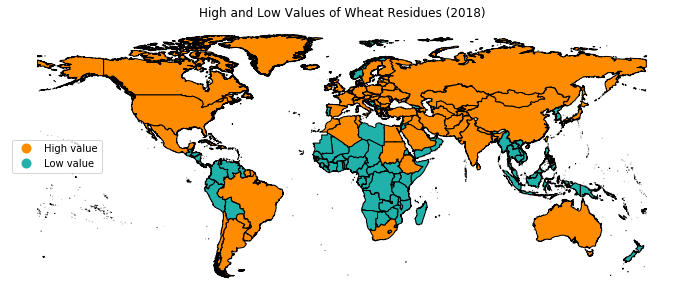

In [25]:
#visualize high and low values
from matplotlib import colors
fig = plt.figure(figsize=(12,10))
ax = plt.gca()
cmap = colors.ListedColormap(['darkorange', 'lightseagreen'])  
wheat18_gs.plot(column='wheat_binary', cmap=cmap ,edgecolor='black', legend=True,legend_kwds=dict(loc='center left'), ax=ax)
ax.set_axis_off()
ax.set_title("High and Low Values of Wheat Residues (2018)")

In [26]:
#global autocorrelation
from pysal.explore import esda 
wheat_18gx_binary = 1 * (wheat18_gs['Wheat_Residue']>wheat18_gs['Wheat_Residue'].median()) # convert back to binary
wheat_W_queen = lps.weights.Queen.from_dataframe(wheat18_gs)
wheat_W_queen.transform = 'b'
#np.random.seed(12345) 
wheat_jc = esda.join_counts.Join_Counts(wheat_18gx_binary,wheat_W_queen)

('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 33, ' is an island (no neighbors)')
('WARNING: ', 37, ' is an island (no neighbors)')
('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 45, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 51, ' is an island (no neighbors)')
('WARNING: ', 52, ' is an island (no neighbors)')
('WARNING: ', 58, ' is an island (no neighbors)')
('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 69, ' is an island (no neighbors)')
('W

Text(0.5, 0, "Moran's I")

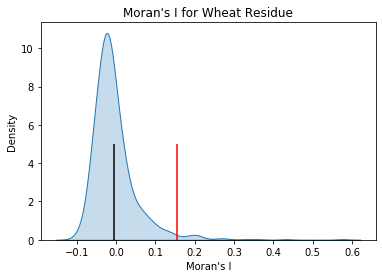

In [27]:
wheat_mi = esda.moran.Moran(wheat18_gs['Wheat_Residue'],wheat_W_queen)
sns.kdeplot(wheat_mi.sim, shade=True)
plt.vlines(wheat_mi.I, 0, 5, color='r')
plt.vlines(wheat_mi.EI, 0, 5)
plt.title("Moran's I for Wheat Residue")
plt.xlabel("Moran's I")

In [28]:
# Check the statistical significance
wheat_mi.p_sim

0.023

In [29]:
wheat_w_queen = Queen.from_dataframe(wheat18_gs)

In [30]:
I_price = ps.explore.esda.Moran(wheat18_gs['Wheat_Residue'].values, wheat_w_queen)  # Moran's I
I_price.I, I_price.p_sim 

('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 33, ' is an island (no neighbors)')
('WARNING: ', 37, ' is an island (no neighbors)')
('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 45, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 51, ' is an island (no neighbors)')
('WARNING: ', 52, ' is an island (no neighbors)')
('WARNING: ', 58, ' is an island (no neighbors)')
('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 69, ' is an island (no neighbors)')
('W

(0.1557922565695196, 0.018)

In [31]:
#local spatial autocorrelation
wheat_lisa = ps.explore.esda.Moran_Local(wheat18_gs['Wheat_Residue'].values,wheat_W_queen, permutations=999)

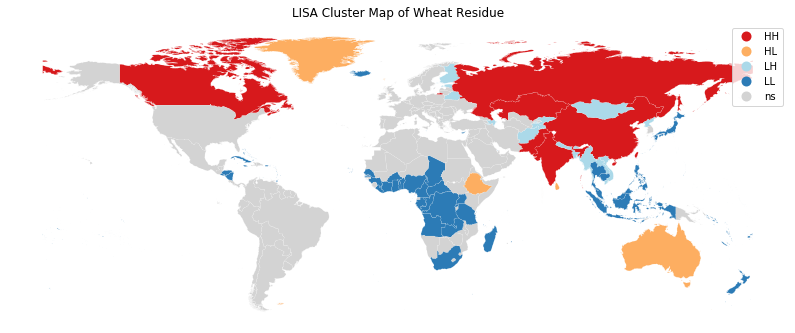

In [32]:
from pysal.viz.splot.esda import lisa_cluster
fig, ax=plt.subplots(1, figsize=(14,10))
fig = lisa_cluster(wheat_lisa,wheat18_gs, ax=ax)
plt.title("LISA Cluster Map of Wheat Residue")
plt.show() 

In [33]:
(wheat_lisa.p_sim < 0.05).sum()

122

In [34]:
wheat18_gs['lag_wheat'] = ps.lib.weights.lag_spatial(wheat_W_queen, wheat18_gs['Wheat_Residue'])
sigs = wheat18_gs['Wheat_Residue'][wheat_lisa.p_sim <= .05]
W_sigs = wheat18_gs['lag_wheat'][wheat_lisa.p_sim <= .05]
insigs = wheat18_gs['Wheat_Residue'][wheat_lisa.p_sim > .05]
W_insigs = wheat18_gs['lag_wheat'][wheat_lisa.p_sim > .05]

Text(0.5, 0, 'Wheat Value(2018)')

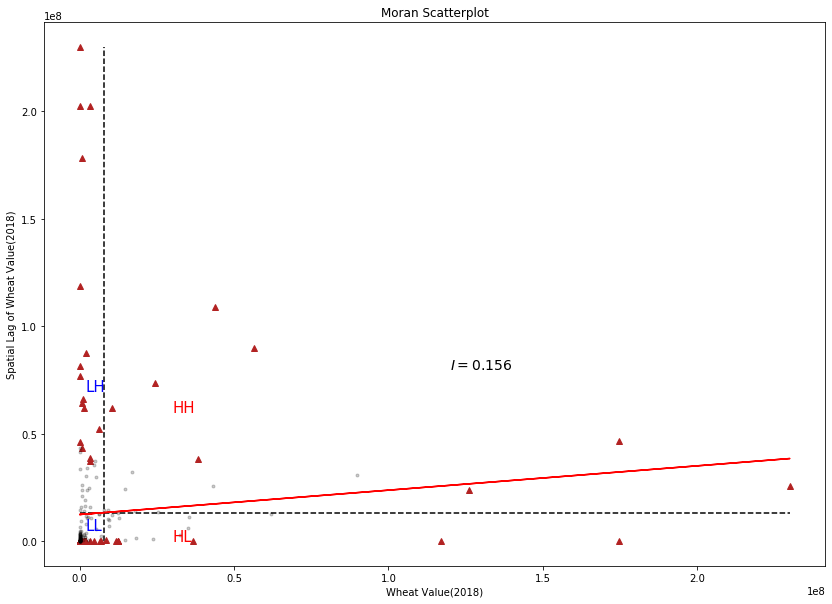

In [35]:
b,a = np.polyfit(wheat18_gs['Wheat_Residue'], wheat18_gs['lag_wheat'], 1)
moran=ps.explore.esda.Moran(wheat18_gs['Wheat_Residue'].values, wheat_W_queen)

fig, ax=plt.subplots(1, figsize=(14,10))
plt.plot(sigs, W_sigs, '^', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(wheat18_gs['Wheat_Residue'].mean(), wheat18_gs['lag_wheat'].min(), wheat18_gs['lag_wheat'].max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(wheat18_gs['lag_wheat'].mean(), wheat18_gs['Wheat_Residue'].min(), wheat18_gs['Wheat_Residue'].max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(wheat18_gs['Wheat_Residue'], a + b*wheat18_gs['Wheat_Residue'], 'r')
plt.text(s='$I = %.3f$' % moran.I, x=120000000, y=80000000, fontsize=14)
plt.text(30000000, 60000000, "HH", fontsize=15, color='r')
plt.text(30000000, 0, "HL", fontsize=15, color='r')
plt.text(2000000, 70000000, "LH", fontsize=15, color='b')
plt.text(2000000, 5000000, "LL", fontsize=15, color='b')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Wheat Value(2018)')
plt.xlabel('Wheat Value(2018)')

In [36]:
#do prediction
#read fertilizer csv 
fertilizers_18=pd.read_csv("dataset/fertilizer/synthetic_fertilizers_per_area_2018.csv",usecols=["Area Code (FAO)","Ferti_Value"])

In [37]:
#merge data
wheat18_g1=pd.merge(wheat18_g,fertilizers_18,on="Area Code (FAO)",how="outer")
wheat18_g1["Area Code (FAO)"]=wheat18_g1["Country Code"]

In [38]:
#fill fertilizer missing values 
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        sum_r=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"Ferti_Value"]):
                k=k+1
                sum_r=sum_r+gdA.loc[j,"Ferti_Value"]
        if k!=0:
            a_sum=sum_r/k
            gdA.loc[i,"Ferti_Value"]=a_sum
while len(wheat18_g1[np.isnan(wheat18_g1["Ferti_Value"].values)].index)!=0:
    ckdnearest(wheat18_g1,wheat18_g1[np.isnan(wheat18_g1["Ferti_Value"].values)].index)

In [39]:
wheat18_g1

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Wheat_Residue,centroid,wheat_binary,lag_wheat,Ferti_Value
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,2.0,6.323275e+06,POINT (66.00845 33.83627),High value,5.197864e+07,5.886300
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,3.0,4.205145e+05,POINT (20.05382 41.14248),Low value,7.679659e+05,35.587700
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,6.967133e+06,POINT (2.65309 28.14889),High value,2.502004e+06,8.242300
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,5.0,6.492972e+05,POINT (-170.39892 -14.25494),Low value,0.000000e+00,0.160700
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,6.0,3.827832e+07,POINT (1.56076 42.54133),High value,3.827832e+07,89.569450
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,4.158000e+03,POINT (17.53699 -12.29232),Low value,6.262029e+04,4.207600
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,258.0,1.683360e+06,POINT (-63.05857 18.22569),High value,0.000000e+00,1.718000
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,8.0,1.683360e+06,POINT (-61.79173 17.28438),High value,0.000000e+00,1.718000
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,3.240658e+07,POINT (-65.17819 -35.38755),High value,2.940815e+06,28.819900
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,1.0,3.280428e+05,POINT (44.93230 40.28813),Low value,1.601197e+07,178.534400


In [40]:
#read csv 
cropland_18=pd.read_csv("dataset/cropland/crop_land_2018.csv",usecols=["Area Code (FAO)","Land_Value"])
cropland_18.head()

,Area Code (FAO),Land_Value
0,3,3050.6290
1,7,5471.1183
2,9,27913.0415
3,10,52921.9173
4,11,2626.2094


In [41]:
wheat18_g2=pd.merge(wheat18_g1,cropland_18,on="Area Code (FAO)",how="outer")

In [42]:
#fill crop land missing values 
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=5)
        land_sum=0
        area_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"Land_Value"]):
                land_sum=land_sum+gdA.loc[j,"Land_Value"]
                area_sum=area_sum+gdA.loc[j,"country_area"]
                k=k+1
        if k!=0:
            gdA.loc[i,"Land_Value"]=(land_sum/area_sum)*gdA.loc[i,"country_area"]
while len(wheat18_g2[np.isnan(wheat18_g2["Land_Value"].values)].index)!=0:
    ckdnearest(wheat18_g2,wheat18_g2[np.isnan(wheat18_g2["Land_Value"].values)].index)

In [43]:
#read climate data
temperature_18=pd.read_csv("dataset/climate/climate18.csv",usecols=["temperature_mean_Wheat","temperature_max","temperature_min","Country Code"])
temperature_18.head()

,temperature_max,temperature_min,Country Code,temperature_mean_Wheat
0,30.82,15.20,101.0,26.880
1,28.62,21.06,131.0,26.190
2,28.51,-11.78,40.0,6.575
3,32.75,-12.02,19.0,25.360
4,37.17,0.07,170.0,24.855


In [44]:
wheat18_g3=pd.merge(wheat18_g2,temperature_18,on="Country Code",how="outer")
wheat18_g3=wheat18_g3.drop([227,228,229,230])
wheat18_g3

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Wheat_Residue,centroid,wheat_binary,lag_wheat,Ferti_Value,Land_Value,temperature_max,temperature_min,temperature_mean_Wheat
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,2.0,6.323275e+06,POINT (66.00845 33.83627),High value,5.197864e+07,5.886300,1.683642e+04,26.80,-11.47,13.870
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,3.0,4.205145e+05,POINT (20.05382 41.14248),Low value,7.679659e+05,35.587700,3.050629e+03,17.65,10.01,11.925
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,6.967133e+06,POINT (2.65309 28.14889),High value,2.502004e+06,8.242300,4.104448e+04,29.87,10.59,25.150
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,5.0,6.492972e+05,POINT (-170.39892 -14.25494),Low value,0.000000e+00,0.160700,6.321889e+00,NaN,NaN,NaN
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,6.0,3.827832e+07,POINT (1.56076 42.54133),High value,3.827832e+07,89.569450,7.308600e+01,NaN,NaN,NaN
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,4.158000e+03,POINT (17.53699 -12.29232),Low value,6.262029e+04,4.207600,5.471118e+03,27.65,18.71,23.705
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,258.0,1.683360e+06,POINT (-63.05857 18.22569),High value,0.000000e+00,1.718000,2.234238e+02,NaN,NaN,NaN
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,8.0,1.683360e+06,POINT (-61.79173 17.28438),High value,0.000000e+00,1.718000,9.637889e+02,NaN,NaN,NaN
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,3.240658e+07,POINT (-65.17819 -35.38755),High value,2.940815e+06,28.819900,2.791304e+04,26.93,-10.92,15.820
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,1.0,3.280428e+05,POINT (44.93230 40.28813),Low value,1.601197e+07,178.534400,5.176354e-01,14.74,6.13,9.910


In [45]:
#fill temperature missing values median
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"temperature_mean_Wheat"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"temperature_mean_Wheat"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"temperature_mean_Wheat"]=a_sum
            
while len(wheat18_g3[np.isnan(wheat18_g3["temperature_mean_Wheat"].values)].index)!=0:
    ckdnearest(wheat18_g3,wheat18_g3[np.isnan(wheat18_g3["temperature_mean_Wheat"].values)].index)

In [46]:
#fill temperature missing values max
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"temperature_max"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"temperature_max"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"temperature_max"]=a_sum
            
while len(wheat18_g3[np.isnan(wheat18_g3["temperature_max"].values)].index)!=0:
    ckdnearest(wheat18_g3,wheat18_g3[np.isnan(wheat18_g3["temperature_max"].values)].index)

In [47]:
#fill temperature missing values min
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"temperature_min"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"temperature_min"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"temperature_min"]=a_sum
while len(wheat18_g3[np.isnan(wheat18_g3["temperature_min"].values)].index)!=0:
    ckdnearest(wheat18_g3,wheat18_g3[np.isnan(wheat18_g3["temperature_min"].values)].index)

In [48]:
#read rainfall data
rainfall_18=pd.read_csv("dataset/climate/rainfall_18.csv",usecols=["Wheat_rainfall_mean","rainfall_max","rainfall_min","Country Code"])
rainfall_18.head()

,rainfall_max,rainfall_min,Country Code,Wheat_rainfall_mean
0,5763.3,1070.8,101.0,2730.9
1,4889.3,2002.7,131.0,3022.9
2,3518.3,18.8,40.0,523.7
3,4620.9,107.8,19.0,1175.9
4,5273.9,6.0,170.0,1556.3


In [49]:
wheat18_g4=pd.merge(wheat18_g3,rainfall_18,on="Country Code",how="outer")
wheat18_g4=wheat18_g4.drop([227,228,229,230])
wheat18_g4

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Wheat_Residue,centroid,wheat_binary,lag_wheat,Ferti_Value,Land_Value,temperature_max,temperature_min,temperature_mean_Wheat,rainfall_max,rainfall_min,Wheat_rainfall_mean
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,2.0,6.323275e+06,POINT (66.00845 33.83627),High value,5.197864e+07,5.886300,1.683642e+04,26.800000,-11.470000,13.870000,1558.7,4.3,430.40
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,3.0,4.205145e+05,POINT (20.05382 41.14248),Low value,7.679659e+05,35.587700,3.050629e+03,17.650000,10.010000,11.925000,1683.5,981.5,1146.90
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,6.967133e+06,POINT (2.65309 28.14889),High value,2.502004e+06,8.242300,4.104448e+04,29.870000,10.590000,25.150000,987.7,9.1,59.40
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,5.0,6.492972e+05,POINT (-170.39892 -14.25494),Low value,0.000000e+00,0.160700,6.321889e+00,16.410000,3.820000,11.525000,NaN,NaN,NaN
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,6.0,3.827832e+07,POINT (1.56076 42.54133),High value,3.827832e+07,89.569450,7.308600e+01,25.440000,6.045000,13.430000,NaN,NaN,NaN
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,4.158000e+03,POINT (17.53699 -12.29232),Low value,6.262029e+04,4.207600,5.471118e+03,27.650000,18.710000,23.705000,2184.4,1.0,1063.85
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,258.0,1.683360e+06,POINT (-63.05857 18.22569),High value,0.000000e+00,1.718000,2.234238e+02,12.140000,10.820000,11.660000,NaN,NaN,NaN
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,8.0,1.683360e+06,POINT (-61.79173 17.28438),High value,0.000000e+00,1.718000,9.637889e+02,12.140000,10.820000,11.660000,NaN,NaN,NaN
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,3.240658e+07,POINT (-65.17819 -35.38755),High value,2.940815e+06,28.819900,2.791304e+04,26.930000,-10.920000,15.820000,2347.6,114.2,577.30
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,1.0,3.280428e+05,POINT (44.93230 40.28813),Low value,1.601197e+07,178.534400,5.176354e-01,14.740000,6.130000,9.910000,623.7,390.9,595.20


In [50]:
#fill rainfall missing values 
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"Wheat_rainfall_mean"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"Wheat_rainfall_mean"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"Wheat_rainfall_mean"]=a_sum
            
while len(wheat18_g4[np.isnan(wheat18_g4["Wheat_rainfall_mean"].values)].index)!=0:
    ckdnearest(wheat18_g4,wheat18_g4[np.isnan(wheat18_g4["Wheat_rainfall_mean"].values)].index)

In [51]:
#fill rainfall missing values  max
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"rainfall_max"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"rainfall_max"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"rainfall_max"]=a_sum
            
while len(wheat18_g4[np.isnan(wheat18_g4["rainfall_max"].values)].index)!=0:
    ckdnearest(wheat18_g4,wheat18_g4[np.isnan(wheat18_g4["rainfall_max"].values)].index)

In [52]:
#fill rainfall missing values  min
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"rainfall_min"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"rainfall_min"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"rainfall_min"]=a_sum
            
while len(wheat18_g4[np.isnan(wheat18_g4["rainfall_min"].values)].index)!=0:
    ckdnearest(wheat18_g4,wheat18_g4[np.isnan(wheat18_g4["rainfall_min"].values)].index)

In [53]:
wheat18_g4.to_csv("dataset/crop_residue_and _indicators/wheat_residue_indicators.csv",columns=["Country Code","Country","CONTINENT","Wheat_Residue","country_area","Ferti_Value","Land_Value",
                                                                 "temperature_max","temperature_min","temperature_mean_Wheat",
                                                                "rainfall_max","rainfall_min", "Wheat_rainfall_mean"])

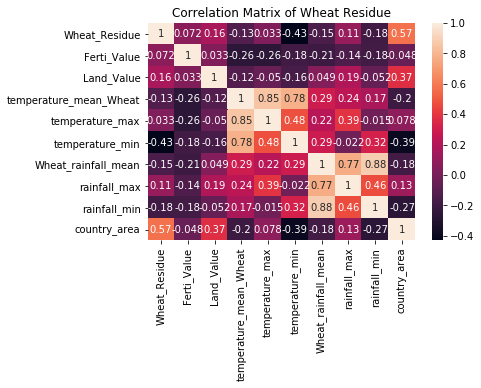

In [54]:
#do prediction
#do coefficient matrix
wheat_df= pd.DataFrame(wheat18_g4,columns=['Wheat_Residue','Ferti_Value',"Land_Value","temperature_mean_Wheat",
                                             "temperature_max","temperature_min","Wheat_rainfall_mean","rainfall_max","rainfall_min","country_area"])
corrMatrix = wheat_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation Matrix of Wheat Residue")
plt.show()

In [55]:
#X=wheat_df[['Ferti_Value',"Land_Value","temperature_mean_Wheat","temperature_max","temperature_min","Wheat_rainfall_mean","rainfall_max","rainfall_min","country_area"]]
X=wheat_df[['Ferti_Value',"temperature_mean_Wheat","temperature_min","Wheat_rainfall_mean","rainfall_max","rainfall_min","country_area"]]
y=wheat_df[['Wheat_Residue']]

In [56]:
import statsmodels.api as sm
y= np.array(y) # define output/dependant variable
# Note the difference in argument order
lm = sm.OLS(y, X).fit()
#lm1.summary()
#evaluation
lm_pre_y = lm.predict(X)
print("Ordinary Least Square model:")
#MAE
#print("mean absolute error:", metrics.mean_absolute_error(y_test.values,lm_pre_y.values))
#MSE
print("root mean squared error:", sqrt(metrics.mean_squared_error(y,lm_pre_y)))
#18430346.72970922
#18457872.256906904

Ordinary Least Square model:
root mean squared error: 19212162.24259807


In [57]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.519
Model:                            OLS   Adj. R-squared (uncentered):              0.504
Method:                 Least Squares   F-statistic:                              33.93
Date:                Fri, 03 Sep 2021   Prob (F-statistic):                    8.24e-32
Time:                        02:20:22   Log-Likelihood:                         -4129.1
No. Observations:                 227   AIC:                                      8272.
Df Residuals:                     220   BIC:                                      8296.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Ferti_Value             1.711e+04    2.2e+04      0.777      0.438   -2.63e+04    6.05e+04
temperature_mean_Wheat  1.435e+06   2.36e+05      6.093      0.000    9.71e+05     1.9e+06
temperature_min        -1.521e+06   2.28e+05     -6.659      0.000   -1.97e+06   -1.07e+06
Wheat_rainfall_mean    -1.617e+04   7416.501     -2.181      0.030   -3.08e+04   -1555.772
rainfall_max            1295.9756   2627.827      0.493      0.622   -3882.960    6474.911
rainfall_min            1.628e+04   5716.254      2.848      0.005    5012.596    2.75e+04
country_area               6.1719      0.825      7.481      0.000       4.546       7.798
==============================================================================
Omnibus:                      240.884   Durbin-Watson:                   2.140
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7581.218
Skew:                           4.310   Prob(JB):                         0.00
Kurtosis:                      29.967   Cond. No.                     4.60e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.6e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
#lasso regression
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import linear_model
lasso=linear_model.Lasso()
lasso.fit(X,y)
lasso_pred=lasso.predict(X)
RMSE=sqrt(mean_squared_error(y,lasso_pred))
print("RMSE:",RMSE)

RMSE: 18875554.266361848


In [59]:
#R-squared
lasso.score(X,y)

0.49531895355209443

In [60]:
#MLP regressor
regr = MLPRegressor(random_state=1, max_iter=500).fit(X, y)
#predict
mlp_pre_y =regr.predict(X)
#MSE
print("root mean squared error:", sqrt(metrics.mean_squared_error(y,mlp_pre_y)))
## R^2
print("R^2 :",regr.score(X,y))

root mean squared error: 21956589.546862278
R^2 : 0.3171153745086983


In [61]:
#spatial error model
wheat_dfg= gpd.GeoDataFrame(wheat18_g4,columns=['Wheat_Residue','Ferti_Value',"temperature_mean_Wheat", "temperature_min","Wheat_rainfall_mean","rainfall_max","rainfall_min","country_area","geometry"])
w_queeng = Queen.from_dataframe(wheat_dfg) 

In [62]:
y_lag=np.array(wheat_dfg["Wheat_Residue"].values)
y_lag.shape = (len(y_lag),1)

In [63]:
X_lag= []
X_lag.append(wheat_df["Ferti_Value"].values) 
X_lag.append(wheat_df["temperature_mean_Wheat"].values)
X_lag.append(wheat_df["temperature_min"].values)
X_lag.append(wheat_df["Wheat_rainfall_mean"].values)
X_lag.append(wheat_df["rainfall_max"].values)
X_lag.append(wheat_df["rainfall_min"].values)
X_lag.append(wheat_df["country_area"].values)
X_lag = np.array(X_lag).T

In [64]:
from pysal.model.spreg import ML_Error
spat_err = ML_Error(y_lag,X_lag,w_queeng, name_y='Wheat_Residue', 
                  name_x=['Ferti_Value',"temperature_mean_Wheat", "temperature_min","Wheat_rainfall_mean","rainfall_max","rainfall_min","country_area"],
                  name_w='w_queeng', name_ds='Wheat_Residue')
print(spat_err.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :Wheat_Residue
Weights matrix      :    w_queeng
Dependent Variable  :Wheat_Residue                Number of Observations:         227
Mean dependent var  :7853462.1796                Number of Variables   :           8
S.D. dependent var  :26628697.5401                Degrees of Freedom    :         219
Pseudo R-squared    :      0.4936
Sigma-square ML     :354500382952095.312                Log likelihood        :   -4124.769
S.E of regression   :18828180.553                Akaike info criterion :    8265.539
                                                 Schwarz criterion     :    8292.938

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------------------------

In [65]:
from sklearn.metrics import mean_squared_error as mse
sqrt(mse(y, spat_err.predy.flatten()))

18908120.93671405

In [66]:
#projection for 2030
#add temperature change
wheat_dfg["temperature_mean_Wheat_2030"]=wheat_dfg["temperature_mean_Wheat"]+0.597
wheat_dfg["temperature_min_2030"]=wheat_dfg["temperature_min"]+0.597

In [67]:
X_2030=wheat_dfg[['Ferti_Value',"temperature_mean_Wheat_2030", "temperature_min_2030","Wheat_rainfall_mean","rainfall_max","rainfall_min","country_area"]]

In [68]:
y_pre_2030=lm.predict(X_2030)

In [69]:
for i in range(0,len(y_pre_2030)):
    if y_pre_2030[i]<0:
         y_pre_2030[i]=(-1)* y_pre_2030[i]

In [70]:
wheat_dfg["Wheat_Residue_2030"]=y_pre_2030

Text(0.5, 1, 'Wheat Residue Quantity (2030)')

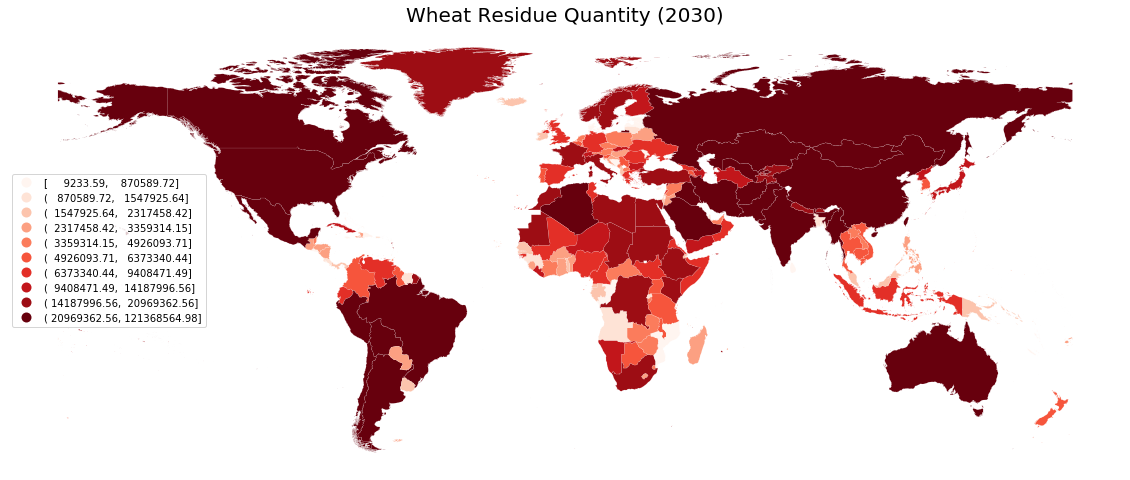

In [71]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
wheat_dfg.plot(column='Wheat_Residue_2030',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,               
       )
ax.set_axis_off()
ax.set_title("Wheat Residue Quantity (2030)", fontsize=20)

In [72]:
#projection for 2040
#add temperature change
wheat_dfg["temperature_mean_Wheat_2040"]=wheat_dfg["temperature_mean_Wheat"]+0.851
wheat_dfg["temperature_min_2040"]=wheat_dfg["temperature_min"]+0.851

In [73]:
X_2040=wheat_dfg[['Ferti_Value',"temperature_mean_Wheat_2040", "temperature_min_2040","Wheat_rainfall_mean","rainfall_max","rainfall_min","country_area"]]

In [74]:
y_pre_2040=lm.predict(X_2040)

In [75]:
for i in range(0,len(y_pre_2040)):
    if y_pre_2040[i]<0:
         y_pre_2040[i]=(-1)* y_pre_2040[i]

In [76]:
wheat_dfg["Wheat_Residue_2040"]=y_pre_2040

Text(0.5, 1, 'Wheat Residue Quantity (2040)')

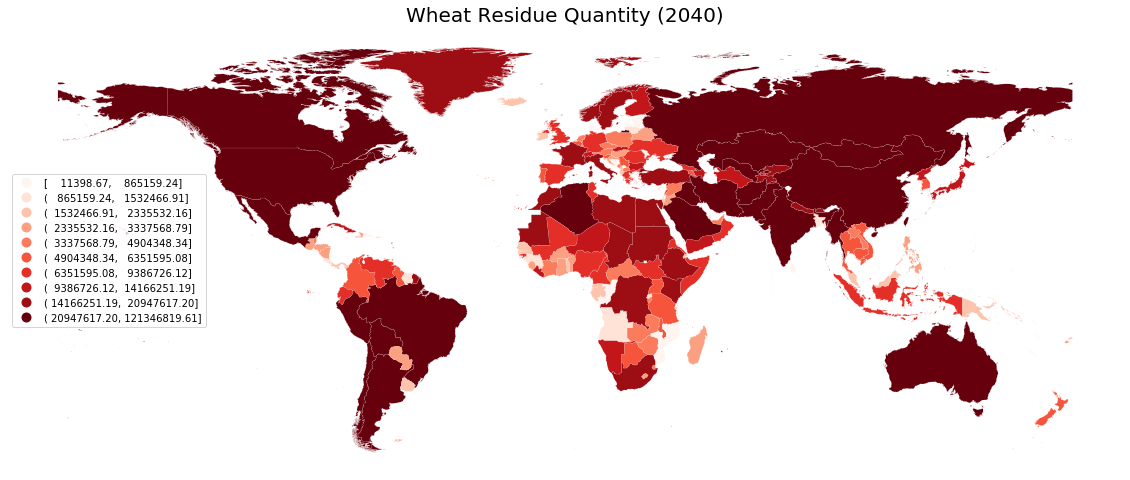

In [77]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
wheat_dfg.plot(column='Wheat_Residue_2040',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,               
       )
ax.set_axis_off()
ax.set_title("Wheat Residue Quantity (2040)", fontsize=20)

In [78]:
#2030
#Cellulose
wheat_dfg["Cellulose_2030"]=wheat_dfg["Wheat_Residue_2030"]*0.38
#Hemicellulose
wheat_dfg["Hemicellulose_2030"]=wheat_dfg["Wheat_Residue_2030"]*0.27
#lignin
wheat_dfg["Lignin_2030"]=wheat_dfg["Wheat_Residue_2030"]*0.36

In [79]:
#2040
#Cellulose
wheat_dfg["Cellulose_2040"]=wheat_dfg["Wheat_Residue_2030"]*0.38
#Hemicellulose
wheat_dfg["Hemicellulose_2040"]=wheat_dfg["Wheat_Residue_2030"]*0.27
#lignin
wheat_dfg["Lignin_2040"]=wheat_dfg["Wheat_Residue_2030"]*0.36

In [80]:
wheat_dfg["Country Code"]=wheat18_g3['Country Code']

In [81]:
wheat_dfg.to_csv("dataset/protein/wheat_protein.csv",columns=["Cellulose_2030","Hemicellulose_2030","Lignin_2030",
                                                                 "Cellulose_2040","Hemicellulose_2040","Lignin_2040",
                                                                 "Country Code"])

In [82]:
diff_2030=wheat_dfg["Wheat_Residue_2030"]-wheat_dfg["Wheat_Residue"]
diff_2040=wheat_dfg["Wheat_Residue_2040"]-wheat_dfg["Wheat_Residue"]

In [83]:
diff_2040

0      3.021058e+07
1      1.794997e+06
2      2.825678e+07
3      8.727637e+06
4     -2.887496e+07
5      1.093328e+06
6     -7.484403e+05
7     -7.463542e+05
8      2.004837e+07
9      5.282476e+06
10    -1.858961e+05
11     2.129615e+07
12     2.292800e+06
13     8.214144e+06
14    -1.028159e+06
15     1.279307e+06
16    -4.006385e+05
17    -1.095161e+06
18    -1.520179e+05
19     2.971670e+06
20     3.621957e+06
21     2.685937e+06
22    -2.442531e+05
23     1.959134e+07
24     4.963008e+07
25     2.258186e+05
26     6.272275e+06
27     3.136490e+07
28    -1.463793e+06
29     3.755026e+06
30     1.690936e+05
31     2.323166e+06
32     3.555679e+06
33     1.705183e+06
34     5.667363e+06
35     6.642446e+06
36     3.533310e+07
37     2.705544e+06
38     3.461052e+06
39     1.913775e+07
40     2.846075e+07
41    -1.179149e+08
42     1.566947e+06
43     9.067674e+03
44     4.998285e+06
45     2.214738e+06
46     1.355022e+05
47     1.371706e+07
48     1.234465e+06
49     4.262436e+06


In [84]:
#value in 2030 larger than the value in 2040
diff_2030 = np.array(diff_2030.values>0 ).sum()
diff_2030

172

In [85]:
diff_2040 = np.array(diff_2040.values>0 ).sum()
diff_2040

172